# sPOD-NN for 2D wildland fire data

In [1]:
import sys
sys.path.append('../sPOD/lib/')
sys.path.append('../DL-ROM/LIB/')

In [2]:
from wildfire2D_sup import wildfire2D_sup
import numpy as np

## Data generation / sPOD of the data

In [3]:
variable = 0  # 0 for temperature and 1 for supply mass fraction
test_val = 558.49

if variable == 0:
    name = "T"
else:
    name = "S"

In [4]:
import os

q = np.load(os.path.abspath(".") + '/wildfire_data/2D/' + 'SnapShotMatrix' + str(test_val) + '.npy')
shifts_test = np.load(os.path.abspath(".") + '/wildfire_data/2D/' + 'Shifts' + str(test_val) + '.npy')

df = wildfire2D_sup(q, shifts_test, param_test_val=test_val, var=variable)

In [5]:
# ############################# Run shifted POD on the data ########################## (only once)
# impath = "./wildfire_data/2D/save_Wildfire/" + name + "/"
# import os
# import pickle
# os.makedirs(impath, exist_ok=True)

# U_list, TA_list_training, TA_list_interp, spod_modes = df.run_sPOD(spod_iter=2000)

# with open(impath + 'U_list.data', 'wb') as filehandle:
#     pickle.dump(U_list, filehandle)
# with open(impath + 'TA_list_training.data', 'wb') as filehandle:
#     pickle.dump(TA_list_training, filehandle)
# with open(impath + 'TA_list_interp.data', 'wb') as filehandle:
#     pickle.dump(TA_list_interp, filehandle)
# with open(impath + 'spod_modes.data', 'wb') as filehandle:
#     pickle.dump(spod_modes, filehandle)
# with open(impath + 'Q_polar_train.data', 'wb') as filehandle:
#     pickle.dump(df.q_polar_train, filehandle)

## Assemble the training data for prediction

In [6]:
impath = "./wildfire_data/2D/save_Wildfire/" + name + "/"
import os
import pickle

with open(impath + 'U_list.data', 'rb') as filehandle:
    U_list = pickle.load(filehandle) 
with open(impath + 'TA_list_training.data', 'rb') as filehandle:
    TA_list_training = pickle.load(filehandle)  
with open(impath + 'TA_list_interp.data', 'rb') as filehandle:
    TA_list_interp = pickle.load(filehandle) 
with open(impath + 'spod_modes.data', 'rb') as filehandle:
    spod_modes = pickle.load(filehandle) 
with open(impath + 'Q_polar_train.data', 'rb') as filehandle:
    Q_polar_train = pickle.load(filehandle) 

In [7]:
from sklearn.utils.extmath import randomized_svd

TA_TRAIN = np.concatenate(TA_list_training, axis=0)
SHIFTS_TRAIN = df.shifts_train[0][0]
PARAMS_TRAIN = df.params_train

u, s, vt = randomized_svd(np.concatenate(df.q_train, axis=1), n_components=sum(spod_modes) + 1, random_state=None)

U_POD_TRAIN = u
TA_POD_TRAIN = np.diag(s) @ vt

## ---------------------------------------------------

In [8]:
# ###################################### Only for DoF study #######################################
# # No need to be performed again 
# # The results are shown in the paper
# from Helper import *
# from wildfire2D_sup import polar_to_cartesian, cartesian_to_polar

# frame_wise_sPOD = [1, 1]
# Nmf = spod_modes
# time_amplitudes_1 = TA_TRAIN[:Nmf[0], :]
# time_amplitudes_2 = TA_TRAIN[Nmf[0]:, :]
# frame_amplitudes_list_training = [
#     time_amplitudes_1[:frame_wise_sPOD[0], :],
#     time_amplitudes_2[:frame_wise_sPOD[1], :]
# ]

# TA_TRAIN = np.concatenate(frame_amplitudes_list_training, axis=0)
# U_list = [
#     U_list[0][:, :frame_wise_sPOD[0]], 
#     U_list[1][:, :frame_wise_sPOD[1]]
# ]
# spod_modes = frame_wise_sPOD

# frame_amplitudes_list_interp = []
# for frame in range(2):
#     Nmodes = spod_modes[frame]
#     VT = frame_amplitudes_list_training[frame]
#     amplitudes = [np.reshape(VT[n, :], [df.Nsamples_train, len(df.t)]).T for n in range(Nmodes)]
#     frame_amplitudes_list_interp.append(amplitudes)

# TA_list_interp = frame_amplitudes_list_interp
# U_POD_TRAIN = U_POD_TRAIN[:, :sum(spod_modes) + 1]
# TA_POD_TRAIN = TA_POD_TRAIN[:sum(spod_modes) + 1, :]

# ############################################
# X_new = df.X - df.x_c  # Shift the origin to the center of the image
# Y_new = df.Y - df.y_c
# r = np.sqrt(X_new ** 2 + Y_new ** 2).flatten()  # polar coordinate r
# theta = np.arctan2(Y_new, X_new).flatten()  # polar coordinate theta
# r_i = np.linspace(np.min(r), np.max(r), df.Nx)
# theta_i = np.linspace(np.min(theta), np.max(theta), df.Ny)
# dr = r_i[1] - r_i[0]
# dtheta = theta_i[1] - theta_i[0]
# d_del = np.asarray([dr, dtheta])
# L = np.asarray([r_i[-1], theta_i[-1]])
# data_shape = [df.Nx, df.Ny, 1, df.Nsamples_train*df.Nt]
# Ndims = 2

# q1 = U_list[0] @ frame_amplitudes_list_training[0] 
# q2 = U_list[1] @ frame_amplitudes_list_training[1]
# q_train = [np.reshape(q1, newshape=data_shape), np.reshape(q2, newshape=data_shape)]

# trafos = [
# transforms(data_shape, L, shifts=df.shifts_train[0], dx=d_del,
#                           use_scipy_transform=True),
# transforms(data_shape, L, shifts=df.shifts_train[1], trafo_type="identity",
#                           dx=d_del,
#                           use_scipy_transform=True)
# ]




# q_train_tmp = [np.reshape(q, newshape=[df.Nx, df.Ny, 1, df.Nt], order="F") for q in df.q_train]
# aux = []
# _, _, _, aux_tmp = cartesian_to_polar(q_train_tmp[0], df.x, df.y, df.t)
# aux.append(aux_tmp)
# for samples in range(df.Nsamples_train - 1):
#     _, _, _, tmp = cartesian_to_polar(q_train_tmp[samples + 1], df.x, df.y, df.t)
#     aux.append(tmp)

# NumFrames = 2
# q_sPOD_polar = 0
# for frame in range(NumFrames):
#     q_sPOD_polar += trafos[frame].apply(q_train[frame])
# q_sPOD = np.zeros_like(q_sPOD_polar)
# for sample in range(df.Nsamples_train):
#     q_sPOD[..., sample * df.Nt:(sample+1) * df.Nt] = polar_to_cartesian(
#         q_sPOD_polar[..., sample * df.Nt:(sample+1) * df.Nt], df.t, aux[sample]
#     ) 
# ############################################
# q_POD = np.reshape(U_POD_TRAIN @ TA_POD_TRAIN, newshape=data_shape)
# ############################################
# q_original = np.concatenate(df.q_train, axis=1)
# q_original = np.reshape(q_original, newshape=data_shape)
# q_original_polar = np.reshape(Q_polar_train, newshape=data_shape)
# ############################################


# res = q_original - q_sPOD
# err_sPOD = np.linalg.norm(np.reshape(res, -1)) / np.linalg.norm(np.reshape(q_original, -1))

# res = q_original - q_POD
# err_POD = np.linalg.norm(np.reshape(res, -1)) / np.linalg.norm(np.reshape(q_original, -1))

# print("Relative reconstruction error indicator for full snapshot(sPOD) is {}".format(err_sPOD))
# print("Relative reconstruction error indicator for full snapshot(POD) is {}".format(err_POD))

## ---------------------------------------------------

## Assemble the testing data

In [9]:
# ############################# Run shifted POD on the test data ########################## (only once)
# import os
# impath = "./wildfire_data/2D/save_Wildfire/" + name + "/" + str(test_val) + "/"
# import pickle
# os.makedirs(impath, exist_ok=True)

# Q_frames_test_polar, Q_frames_test_cart, conv_param = df.test_data(spod_iter=1000)


# with open(impath + 'Q_frames_test_polar.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test_polar, filehandle)
# with open(impath + 'Q_frames_test_cart.data', 'wb') as filehandle:
#     pickle.dump(Q_frames_test_cart, filehandle)
# with open(impath + 'Q_test_polar.data', 'wb') as filehandle:
#     pickle.dump(df.q_polar_test, filehandle)
# with open(impath + 'conv_param.data', 'wb') as filehandle:
#     pickle.dump(conv_param, filehandle)

In [10]:
impath = "./wildfire_data/2D/save_Wildfire/" + name + "/" + str(test_val) + "/"
import os
import pickle

with open(impath + 'Q_frames_test_polar.data', 'rb') as filehandle:
    Q_frames_test_polar = pickle.load(filehandle) 
with open(impath + 'Q_frames_test_cart.data', 'rb') as filehandle:
    Q_frames_test_cart = pickle.load(filehandle) 
with open(impath + 'Q_test_polar.data', 'rb') as filehandle:
    Q_test_polar = pickle.load(filehandle) 
with open(impath + 'conv_param.data', 'rb') as filehandle:
    conv_param = pickle.load(filehandle)

In [11]:
# # Plot the frames for test parameter
# df.plot_sPOD_frames(Q_frames_test_cart, plot_every=10, var_name="T")

In [12]:
mu_vecs_test = np.asarray([df.param_test_val])
params_test = [np.squeeze(np.asarray([[np.ones_like(df.t) * mu], [df.t]])) for mu in mu_vecs_test]
PARAMS_TEST = np.concatenate(params_test, axis=1)

q1_test = Q_frames_test_polar[0]
q2_test = Q_frames_test_polar[1]
time_amplitudes_1_test = U_list[0].transpose() @ q1_test
time_amplitudes_2_test = U_list[1].transpose() @ q2_test

TA_TEST = np.concatenate((time_amplitudes_1_test, time_amplitudes_2_test), axis=0)
SHIFTS_TEST = df.shifts_test[0][0]
TA_POD_TEST = U_POD_TRAIN.transpose() @ df.q_test

# -----------------------------------------------------------

In [13]:
print("Grid, Nx : {}, Ny : {}, Nt : {}".format(len(df.x), len(df.y), len(df.t)))
print("Number of sPOD frames : {}".format(len(spod_modes)))
print("Number of modes (frame wise) : {}, {}".format(spod_modes[0], spod_modes[1]))
print("Size of training matrix : {} x {}".format(int(TA_TRAIN.shape[0]), int(TA_TRAIN.shape[1])))

Grid, Nx : 500, Ny : 500, Nt : 100
Number of sPOD frames : 2
Number of modes (frame wise) : 19, 5
Size of training matrix : 24 x 500


In [14]:
shifts_train = np.reshape(SHIFTS_TRAIN, newshape=[1, -1])
shifts_test = np.reshape(SHIFTS_TEST, newshape=[1, -1])

ta_train = np.concatenate((TA_TRAIN, shifts_train), axis=0)
ta_test = np.concatenate((TA_TEST, shifts_test), axis=0)

## Network prediction

In [15]:
params_sPOD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': len(df.x) * len(df.y),  # N_h
        'reduced_order_model_dimension': ta_train.shape[0],  # N
        'totalModes': ta_train.shape[0] - len(spod_modes) + 1,  # Total number of modes for all the frames
        'num_early_stop': 4000  # Early stop criteria 
    }
params_POD = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': len(df.x) * len(df.y),  # N_h
        'reduced_order_model_dimension': TA_POD_TRAIN.shape[0],  # N
        'totalModes': TA_POD_TRAIN.shape[0],  # Total number of modes for all the frames
        'num_early_stop': 4000  # Early stop criteria 
    }

In [16]:
# # training the model
# from DFNN import run_model 
# import time
# tic_sPOD = time.process_time() 
# print("#################################")
# print("sPOD-NN")
# model_sPOD, _, scaling_sPOD = run_model(ta_train, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                         logs_folder='./DNN_result/wildfire2D/training_results_sPOD/' + name, 
#                                         params=params_sPOD, batch_size=50)
# print("#################################\n")
# toc_sPOD = time.process_time()

# tic_POD = time.process_time()
# print("#################################")
# print("POD-NN")
# model_POD, _, scaling_POD = run_model(TA_POD_TRAIN, PARAMS_TRAIN, epochs=200000, lr=0.005, loss_type='L1', 
#                                       logs_folder='./DNN_result/wildfire2D/training_results_POD/' + name, 
#                                       params=params_POD, batch_size=50)
# print("#################################\n")
# toc_POD = time.process_time()

# print(f"Time consumption in training (sPOD-NN) : {toc_sPOD - tic_sPOD:0.4f} seconds")
# print(f"Time consumption in training (POD-NN) : {toc_POD - tic_POD:0.4f} seconds")

## Network testing

In [17]:
# Choose if you want to do a query test "query" or full test "full"
test = {
    'typeOfTest': "full",
    'test_sample': 40
}

In [18]:
import torch
import pathlib
import os
from DFNN import scale_params

# Load the correct model
log_folder_base_sPOD = 'DNN_result/wildfire2D/training_results_sPOD/' + name + '/'
log_folder_trained_model_sPOD = sorted(pathlib.Path(log_folder_base_sPOD).glob('*/'), key=os.path.getmtime)[-1]
PATH_sPOD = str(log_folder_trained_model_sPOD) + '/trained_weights/' + 'weights.pt'

log_folder_base_POD = 'DNN_result/wildfire2D/training_results_POD/' + name + '/'
log_folder_trained_model_POD = sorted(pathlib.Path(log_folder_base_POD).glob('*/'), key=os.path.getmtime)[-1]
PATH_POD = str(log_folder_trained_model_POD) + '/trained_weights/' + 'weights.pt'

PATH_sPOD = 'DNN_result/wildfire2D/training_results_sPOD/' + name + '/2023_03_09__10-35-48/trained_weights/weights.pt'
PATH_POD = 'DNN_result/wildfire2D/training_results_POD/' + name + '/2023_03_09__10-44-59/trained_weights/weights.pt'

# Scale the parameters before prediction
if '/trained_weights/weights.pt' in PATH_sPOD: address_sPOD = PATH_sPOD.replace('/trained_weights/weights.pt', '')
scaling_sPOD = np.load(address_sPOD + '/variables/' + 'scaling.npy', allow_pickle=True)

if '/trained_weights/weights.pt' in PATH_POD: address_POD = PATH_POD.replace('/trained_weights/weights.pt', '')
scaling_POD = np.load(address_POD + '/variables/' + 'scaling.npy', allow_pickle=True)

PARAMS_TEST_sPOD = scale_params(PARAMS_TEST, params_sPOD, scaling_sPOD)
PARAMS_TEST_POD = scale_params(PARAMS_TEST, params_POD, scaling_POD)

cpu


In [19]:
if test['typeOfTest'] == "query":
    test_sample = test['test_sample']
    
    ta_test = ta_test[:, test_sample][..., np.newaxis]
    
    TA_TEST = TA_TEST[:, test_sample][..., np.newaxis]
    TA_POD_TEST = TA_POD_TEST[:, test_sample][..., np.newaxis]
    
    tmp = []
    for i in range(df.NumFrames):
        tt = []
        for m in range(spod_modes[i]):
            ampl = TA_list_interp[i][m][test_sample, :][np.newaxis, ...]
            tt.append(ampl)
        tmp.append(tt)
    TA_list_interp = tmp
    
    SHIFTS_TEST = SHIFTS_TEST[test_sample]
    
    PARAMS_TEST_sPOD = PARAMS_TEST_sPOD[:, test_sample][..., np.newaxis]
    PARAMS_TEST_POD = PARAMS_TEST_POD[:, test_sample][..., np.newaxis]

In [20]:
# testing the model
from DFNN import test_model 
import time 

tic = time.process_time()
rel_err_sPOD, results_predicted_sPOD = test_model(ta_test, PARAMS_TEST_sPOD, trained_model=None, saved_model=True, 
                                                  PATH_TO_WEIGHTS=PATH_sPOD, params=params_sPOD, scaling=scaling_sPOD, 
                                                  batch_size=50) 
toc = time.process_time()
print(f"Time consumption in testing sPOD-NN model : {toc - tic:0.4f} seconds")

tic = time.process_time()
rel_err_POD, results_predicted_POD = test_model(TA_POD_TEST, PARAMS_TEST_POD, trained_model=None, saved_model=True, 
                                                PATH_TO_WEIGHTS=PATH_POD, params=params_POD, scaling=scaling_POD, 
                                                batch_size=50)
toc = time.process_time()
print(f"Time consumption in testing POD-NN model : {toc - tic:0.4f} seconds")


print(rel_err_sPOD, rel_err_POD)

Time consumption in testing sPOD-NN model : 0.0057 seconds
Time consumption in testing POD-NN model : 0.0017 seconds
0.0885748 0.044006314


# -----------------------------------------------------------

In [21]:
# This cell is reserved for data manipulations for the online analysis
frame_amplitudes_predicted_sPOD = results_predicted_sPOD[:-1, :]
shifts_predicted_sPOD = results_predicted_sPOD[-1:, :]
frame_amplitudes_predicted_POD = results_predicted_POD

In [22]:
Q_recon_sPOD_cart, Q_recon_POD_cart, Q_recon_interp_cart, errors = df.plot_online_data(frame_amplitudes_predicted_sPOD, 
                                                                                       frame_amplitudes_predicted_POD, 
                                                                                       TA_TEST, TA_POD_TEST, TA_list_interp,
                                                                                       shifts_predicted_sPOD, SHIFTS_TEST, 
                                                                                       spod_modes, U_list, U_POD_TRAIN, 
                                                                                       Q_test_polar, Q_frames_test_polar,
                                                                                       conv_param, plot_online=False, 
                                                                                       test_type=test)

#############################################
Online Error checks
Check 1...
Relative error indicator for shift for frame 1 (sPOD-NN): 0.008436302592046977
Relative error indicator for shift for frame 1 (sPOD-I): 0.0071553151019289355
Check 2...
Relative time amplitude error indicator (polar) for frame 1 (sPOD-NN): 0.08700654978514206
Relative time amplitude error indicator (polar) for frame 2 (sPOD-NN): 0.09966511503683333
Relative time amplitude error indicator (polar) for frame 1 (sPOD-I): 0.08384140506978373
Relative time amplitude error indicator (polar) for frame 2 (sPOD-I): 0.02841341589159021
Relative time amplitude error indicator (polar) (POD-NN): 0.04400631720166792
Check 3...
Relative reconstruction error indicator for full snapshot (polar) (sPOD-NN): 0.035449368813529746
Relative reconstruction error indicator for full snapshot (polar) (sPOD-I): 0.022966984751719193
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
3

In [23]:
# if test['typeOfTest'] != "query":
#     df.plot_recon(Q_recon_sPOD_cart, Q_recon_POD_cart, Q_recon_interp_cart, t_a=10, t_b=100)

## Erros Plots

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os
from Helper import save_fig
from statistics import mean

impath = "../plots/images_wildfire2D/"
os.makedirs(impath, exist_ok=True) 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"]})

SMALL_SIZE = 16   # 16
MEDIUM_SIZE = 18   # 18
BIGGER_SIZE = 20   # 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


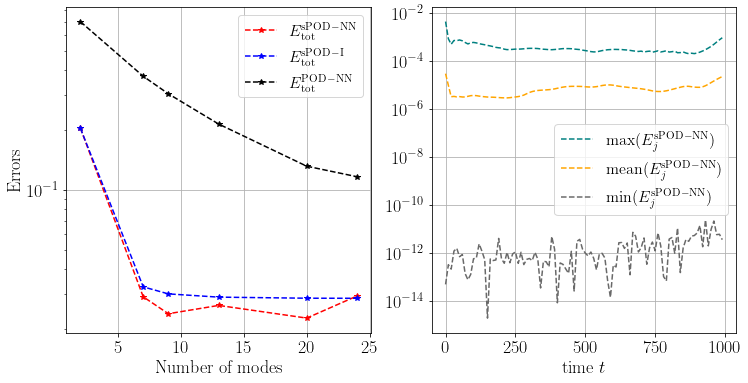

In [25]:
truncated_modes = np.array([2, 7, 9, 13, 20, 24])
E_sPOD_NN = np.array([0.20504, 0.02914, 0.02397, 0.02638, 0.02279, 0.02942])
E_sPOD_I = np.array([0.20452, 0.03269, 0.03014, 0.02903, 0.02867, 0.02865])
E_POD_NN = np.array([0.69972, 0.37205, 0.30384, 0.21423, 0.13170, 0.11663])

err = errors[0]
err_max = [max(x) for x in err]
err_min = [min(x) for x in err]
err_mean = [mean(x) for x in err]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].semilogy(truncated_modes, E_sPOD_NN, color="red", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-NN}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_sPOD_I, color="blue", linestyle='--', marker="*", label=r"$E^{\mathrm{sPOD-I}}_{\mathrm{tot}}$")
axs[0].semilogy(truncated_modes, E_POD_NN, color="black", linestyle='--', marker="*", label=r"$E^{\mathrm{POD-NN}}_{\mathrm{tot}}$")
axs[0].set_xlabel('Number of modes')
axs[0].set_ylabel('Errors')
axs[0].grid()
axs[0].legend(loc='upper right')

axs[1].semilogy(df.t, err_max, color="teal", linestyle='--', label=r"max$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].semilogy(df.t, err_mean, color="orange", linestyle='--', label=r"mean$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].semilogy(df.t, err_min, color="dimgrey", linestyle='--', label=r"min$(E^{\mathrm{sPOD-NN}}_j)$")
axs[1].set_xlabel(r"time $t$")
axs[1].grid()
axs[1].legend(loc='center right')

save_fig(filepath=impath + 'Rel_err', figure=fig)
fig.savefig(impath + "Rel_err" + ".eps", format='eps',dpi=600, transparent=True)